# Import libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as VF

import torchvision
from torchvision import datasets, transforms

# Load MNIST datasets

## Add custom transform class to add Gaussian Noise

In [34]:
# Custom transform class to en-noise image data
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        noisy = tensor + torch.normal(mean=self.mean, std=self.std, size=tensor.size())
        noisy = torch.clamp(noisy, 0.0, 0.5)
        return (noisy, tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

# Utility function to visualize image batches in grids
def show(imgs, title=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
    fig.suptitle(title)
    plt.show()

## Load MNIST datasets

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.8)
])

mnist_data = torchvision.datasets.MNIST(
    '/tmp/mnist', 
    download=True, 
    train=True, 
    transform=transform
)

loader = torch.utils.data.DataLoader(
    mnist_data,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

## Visualize noisy and normal samples

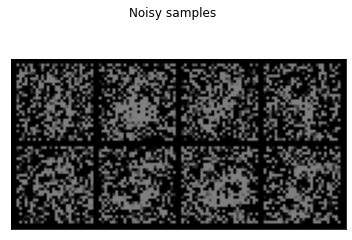

In [36]:
(images, normal), labels = next(iter(loader))
grid = torchvision.utils.make_grid(images, nrow=4, pad_value=0)
show(grid, title='Noisy samples')

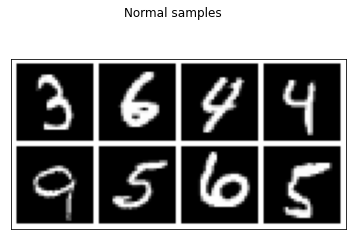

In [37]:
grid = torchvision.utils.make_grid(normal, nrow=4, pad_value=1)
show(grid, title='Normal samples')

# Define the network architecture

In [38]:
class ISTA_Module(nn.Module):
    def __init__(self, input_dim):
        super(ISTA_Module, self).__init__()
        self._lambda = nn.Parameter(data=torch.normal(size=(1,), std=1.0, mean=0.0))
        self.linear1 = nn.Linear(in_features=input_dim, out_features=input_dim)
        self.linear2 = nn.Linear(in_features=input_dim, out_features=input_dim)
        
    def soft_thresholding(self, x):
        return torch.sign(x) * F.relu(torch.abs(x) - self._lambda)
    
    def forward(self, x, y):
        # outputs = self.soft_thresholding(x @ self._We + y @ self._Wt)
        outputs = self.soft_thresholding(self.linear1(x) + self.linear2(y))
        
        return outputs
    
class LISTA(nn.Module):
    def __init__(self, input_dim, L=10):
        super(LISTA, self).__init__()
        self.input_dim = input_dim
        self.L = L
    
        self.ista_modules = nn.ModuleList()
        
        for i in range(self.L):
            self.ista_modules.append(ISTA_Module(input_dim=self.input_dim))
        
    def forward(self, y):
        x = torch.zeros_like(y)
        
        for layer in self.ista_modules:
            x = layer(x, y)
            
        return x
    
class DenoiseNetwork(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super(DenoiseNetwork, self).__init__()
        self.num_layers = num_layers
        self.batchnorms = nn.ModuleList()
        self.layers = nn.ModuleList()
        
        for i in range(self.num_layers):
            self.layers.append(nn.Linear(in_features=input_dim, out_features=input_dim))
            self.layers.append(nn.BatchNorm1d(input_dim))
            
    def forward(self, x):
        outputs = x
        
        for norm, layer in zip(self.batchnorms, self.layers):
            x = layer(x)
            x = F.relu(x)
            x = norm(x)
            
        outputs = F.sigmoid(x)
        return outputs

In [39]:
(noisy, normal), labels = next(iter(loader))
noisy = torch.flatten(noisy, 1)
normal = torch.flatten(normal, 1)

input_dim = noisy.shape[1]

# Define a LISTA for sparse representation learning and a simple network for denoising

In [44]:
lista = LISTA(input_dim, L=3)
network = DenoiseNetwork(input_dim, num_layers=1)

optimizer1 = optim.Adam(lista.parameters(), lr=0.0001)
optimizer2 = optim.Adam(network.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 10 

try:
    for i in range(epochs):
        for j, ((noisy, normal), labels) in enumerate(loader):  
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            noisy = torch.flatten(noisy, 1)
            normal = torch.flatten(normal, 1)

            x = lista(noisy)
            outputs = network(x)

            loss = criterion(outputs, normal)

            print(f'[INFO] Epoch #[{i+1}/{epochs}], batch #[{j}/{len(loader)}], loss = {loss.item()}')

            loss.backward()

            optimizer1.step()
            optimizer2.step()
except KeyboardInterrupt:
    print('[INFO] Training halted ... ')


[INFO] Epoch #[1/10], batch #[0/7500], loss = 0.22952240705490112
[INFO] Epoch #[1/10], batch #[1/7500], loss = 0.22993966937065125
[INFO] Epoch #[1/10], batch #[2/7500], loss = 0.2310507446527481
[INFO] Epoch #[1/10], batch #[3/7500], loss = 0.2328117936849594
[INFO] Epoch #[1/10], batch #[4/7500], loss = 0.23121094703674316
[INFO] Epoch #[1/10], batch #[5/7500], loss = 0.23164889216423035
[INFO] Epoch #[1/10], batch #[6/7500], loss = 0.2316029965877533
[INFO] Epoch #[1/10], batch #[7/7500], loss = 0.22997057437896729
[INFO] Epoch #[1/10], batch #[8/7500], loss = 0.23188287019729614
[INFO] Epoch #[1/10], batch #[9/7500], loss = 0.23162174224853516
[INFO] Epoch #[1/10], batch #[10/7500], loss = 0.23244395852088928
[INFO] Epoch #[1/10], batch #[11/7500], loss = 0.23360037803649902
[INFO] Epoch #[1/10], batch #[12/7500], loss = 0.23134830594062805
[INFO] Epoch #[1/10], batch #[13/7500], loss = 0.23038049042224884
[INFO] Epoch #[1/10], batch #[14/7500], loss = 0.2318025678396225
[INFO] Ep

[INFO] Epoch #[1/10], batch #[130/7500], loss = 0.17982235550880432
[INFO] Epoch #[1/10], batch #[131/7500], loss = 0.18083100020885468
[INFO] Epoch #[1/10], batch #[132/7500], loss = 0.179859459400177
[INFO] Epoch #[1/10], batch #[133/7500], loss = 0.17727793753147125
[INFO] Epoch #[1/10], batch #[134/7500], loss = 0.17908889055252075
[INFO] Epoch #[1/10], batch #[135/7500], loss = 0.17998109757900238
[INFO] Epoch #[1/10], batch #[136/7500], loss = 0.17969194054603577
[INFO] Epoch #[1/10], batch #[137/7500], loss = 0.17547762393951416
[INFO] Epoch #[1/10], batch #[138/7500], loss = 0.17507700622081757
[INFO] Epoch #[1/10], batch #[139/7500], loss = 0.1728333681821823
[INFO] Epoch #[1/10], batch #[140/7500], loss = 0.1745627522468567
[INFO] Epoch #[1/10], batch #[141/7500], loss = 0.17681530117988586
[INFO] Epoch #[1/10], batch #[142/7500], loss = 0.1747765839099884
[INFO] Epoch #[1/10], batch #[143/7500], loss = 0.17263060808181763
[INFO] Epoch #[1/10], batch #[144/7500], loss = 0.171

[INFO] Epoch #[1/10], batch #[256/7500], loss = 0.12152860313653946
[INFO] Epoch #[1/10], batch #[257/7500], loss = 0.1305372714996338
[INFO] Epoch #[1/10], batch #[258/7500], loss = 0.12589167058467865
[INFO] Epoch #[1/10], batch #[259/7500], loss = 0.1318206638097763
[INFO] Epoch #[1/10], batch #[260/7500], loss = 0.12338874489068985
[INFO] Epoch #[1/10], batch #[261/7500], loss = 0.13037244975566864
[INFO] Epoch #[1/10], batch #[262/7500], loss = 0.12833957374095917
[INFO] Epoch #[1/10], batch #[263/7500], loss = 0.13337701559066772
[INFO] Epoch #[1/10], batch #[264/7500], loss = 0.1264951229095459
[INFO] Epoch #[1/10], batch #[265/7500], loss = 0.13059717416763306
[INFO] Epoch #[1/10], batch #[266/7500], loss = 0.1292596012353897
[INFO] Epoch #[1/10], batch #[267/7500], loss = 0.1213383600115776
[INFO] Epoch #[1/10], batch #[268/7500], loss = 0.13083666563034058
[INFO] Epoch #[1/10], batch #[269/7500], loss = 0.13268092274665833
[INFO] Epoch #[1/10], batch #[270/7500], loss = 0.130

[INFO] Epoch #[1/10], batch #[384/7500], loss = 0.11824455857276917
[INFO] Epoch #[1/10], batch #[385/7500], loss = 0.11943530291318893
[INFO] Epoch #[1/10], batch #[386/7500], loss = 0.11793746799230576
[INFO] Epoch #[1/10], batch #[387/7500], loss = 0.11575222760438919
[INFO] Epoch #[1/10], batch #[388/7500], loss = 0.11628396064043045
[INFO] Epoch #[1/10], batch #[389/7500], loss = 0.11695730686187744
[INFO] Epoch #[1/10], batch #[390/7500], loss = 0.11137542873620987
[INFO] Epoch #[1/10], batch #[391/7500], loss = 0.11077123880386353
[INFO] Epoch #[1/10], batch #[392/7500], loss = 0.11312466859817505
[INFO] Epoch #[1/10], batch #[393/7500], loss = 0.13355669379234314
[INFO] Epoch #[1/10], batch #[394/7500], loss = 0.11849689483642578
[INFO] Epoch #[1/10], batch #[395/7500], loss = 0.11794085055589676
[INFO] Epoch #[1/10], batch #[396/7500], loss = 0.10808335244655609
[INFO] Epoch #[1/10], batch #[397/7500], loss = 0.11888115108013153
[INFO] Epoch #[1/10], batch #[398/7500], loss = 

[INFO] Epoch #[1/10], batch #[505/7500], loss = 0.11292842775583267
[INFO] Epoch #[1/10], batch #[506/7500], loss = 0.11164617538452148
[INFO] Epoch #[1/10], batch #[507/7500], loss = 0.11626994609832764
[INFO] Epoch #[1/10], batch #[508/7500], loss = 0.11173145473003387
[INFO] Epoch #[1/10], batch #[509/7500], loss = 0.1113222986459732
[INFO] Epoch #[1/10], batch #[510/7500], loss = 0.11078977584838867
[INFO] Epoch #[1/10], batch #[511/7500], loss = 0.11236647516489029
[INFO] Epoch #[1/10], batch #[512/7500], loss = 0.11554526537656784
[INFO] Epoch #[1/10], batch #[513/7500], loss = 0.11872885376214981
[INFO] Epoch #[1/10], batch #[514/7500], loss = 0.11563292145729065
[INFO] Epoch #[1/10], batch #[515/7500], loss = 0.10937216877937317
[INFO] Epoch #[1/10], batch #[516/7500], loss = 0.11982452869415283
[INFO] Epoch #[1/10], batch #[517/7500], loss = 0.11238651722669601
[INFO] Epoch #[1/10], batch #[518/7500], loss = 0.11362878978252411
[INFO] Epoch #[1/10], batch #[519/7500], loss = 0

[INFO] Epoch #[1/10], batch #[626/7500], loss = 0.11045490205287933
[INFO] Epoch #[1/10], batch #[627/7500], loss = 0.11387703567743301
[INFO] Epoch #[1/10], batch #[628/7500], loss = 0.10557352751493454
[INFO] Epoch #[1/10], batch #[629/7500], loss = 0.10530127584934235
[INFO] Epoch #[1/10], batch #[630/7500], loss = 0.10445676743984222
[INFO] Epoch #[1/10], batch #[631/7500], loss = 0.11444927752017975
[INFO] Epoch #[1/10], batch #[632/7500], loss = 0.10629762709140778
[INFO] Epoch #[1/10], batch #[633/7500], loss = 0.11524152010679245
[INFO] Epoch #[1/10], batch #[634/7500], loss = 0.11285632848739624
[INFO] Epoch #[1/10], batch #[635/7500], loss = 0.11239414662122726
[INFO] Epoch #[1/10], batch #[636/7500], loss = 0.10532258450984955
[INFO] Epoch #[1/10], batch #[637/7500], loss = 0.11290484666824341
[INFO] Epoch #[1/10], batch #[638/7500], loss = 0.10712872445583344
[INFO] Epoch #[1/10], batch #[639/7500], loss = 0.1127203032374382
[INFO] Epoch #[1/10], batch #[640/7500], loss = 0

[INFO] Epoch #[1/10], batch #[752/7500], loss = 0.10697829723358154
[INFO] Epoch #[1/10], batch #[753/7500], loss = 0.10210955142974854
[INFO] Epoch #[1/10], batch #[754/7500], loss = 0.10113855451345444
[INFO] Epoch #[1/10], batch #[755/7500], loss = 0.1074085533618927
[INFO] Epoch #[1/10], batch #[756/7500], loss = 0.10481628775596619
[INFO] Epoch #[1/10], batch #[757/7500], loss = 0.11610203236341476
[INFO] Epoch #[1/10], batch #[758/7500], loss = 0.11075006425380707
[INFO] Epoch #[1/10], batch #[759/7500], loss = 0.10226691514253616
[INFO] Epoch #[1/10], batch #[760/7500], loss = 0.10672744363546371
[INFO] Epoch #[1/10], batch #[761/7500], loss = 0.11461982876062393
[INFO] Epoch #[1/10], batch #[762/7500], loss = 0.10806507617235184
[INFO] Epoch #[1/10], batch #[763/7500], loss = 0.10850263386964798
[INFO] Epoch #[1/10], batch #[764/7500], loss = 0.10439727455377579
[INFO] Epoch #[1/10], batch #[765/7500], loss = 0.10852035135030746
[INFO] Epoch #[1/10], batch #[766/7500], loss = 0

[INFO] Epoch #[1/10], batch #[873/7500], loss = 0.10987367480993271
[INFO] Epoch #[1/10], batch #[874/7500], loss = 0.0999860092997551
[INFO] Epoch #[1/10], batch #[875/7500], loss = 0.10833947360515594
[INFO] Epoch #[1/10], batch #[876/7500], loss = 0.10718168318271637
[INFO] Epoch #[1/10], batch #[877/7500], loss = 0.10757504403591156
[INFO] Epoch #[1/10], batch #[878/7500], loss = 0.10387340188026428
[INFO] Epoch #[1/10], batch #[879/7500], loss = 0.10049135982990265
[INFO] Epoch #[1/10], batch #[880/7500], loss = 0.10379404574632645
[INFO] Epoch #[1/10], batch #[881/7500], loss = 0.1006975769996643
[INFO] Epoch #[1/10], batch #[882/7500], loss = 0.10192488878965378
[INFO] Epoch #[1/10], batch #[883/7500], loss = 0.11403144150972366
[INFO] Epoch #[1/10], batch #[884/7500], loss = 0.09577398747205734
[INFO] Epoch #[1/10], batch #[885/7500], loss = 0.11345911026000977
[INFO] Epoch #[1/10], batch #[886/7500], loss = 0.10833130776882172
[INFO] Epoch #[1/10], batch #[887/7500], loss = 0.

[INFO] Epoch #[1/10], batch #[995/7500], loss = 0.0996675193309784
[INFO] Epoch #[1/10], batch #[996/7500], loss = 0.10433237254619598
[INFO] Epoch #[1/10], batch #[997/7500], loss = 0.10080962628126144
[INFO] Epoch #[1/10], batch #[998/7500], loss = 0.10035037994384766
[INFO] Epoch #[1/10], batch #[999/7500], loss = 0.09968824684619904
[INFO] Epoch #[1/10], batch #[1000/7500], loss = 0.10348737239837646
[INFO] Epoch #[1/10], batch #[1001/7500], loss = 0.10541769117116928
[INFO] Epoch #[1/10], batch #[1002/7500], loss = 0.0962567999958992
[INFO] Epoch #[1/10], batch #[1003/7500], loss = 0.10060548782348633
[INFO] Epoch #[1/10], batch #[1004/7500], loss = 0.10265819728374481
[INFO] Epoch #[1/10], batch #[1005/7500], loss = 0.09674212336540222
[INFO] Epoch #[1/10], batch #[1006/7500], loss = 0.10469929873943329
[INFO] Epoch #[1/10], batch #[1007/7500], loss = 0.09877964854240417
[INFO] Epoch #[1/10], batch #[1008/7500], loss = 0.10554506629705429
[INFO] Epoch #[1/10], batch #[1009/7500],

[INFO] Epoch #[1/10], batch #[1122/7500], loss = 0.09796265512704849
[INFO] Epoch #[1/10], batch #[1123/7500], loss = 0.10266895592212677
[INFO] Epoch #[1/10], batch #[1124/7500], loss = 0.10377103090286255
[INFO] Epoch #[1/10], batch #[1125/7500], loss = 0.10219554603099823
[INFO] Epoch #[1/10], batch #[1126/7500], loss = 0.10420434176921844
[INFO] Epoch #[1/10], batch #[1127/7500], loss = 0.09818410873413086
[INFO] Epoch #[1/10], batch #[1128/7500], loss = 0.09908609092235565
[INFO] Epoch #[1/10], batch #[1129/7500], loss = 0.10121818631887436
[INFO] Epoch #[1/10], batch #[1130/7500], loss = 0.09473233669996262
[INFO] Epoch #[1/10], batch #[1131/7500], loss = 0.09892008453607559
[INFO] Epoch #[1/10], batch #[1132/7500], loss = 0.08998330682516098
[INFO] Epoch #[1/10], batch #[1133/7500], loss = 0.09356424957513809
[INFO] Epoch #[1/10], batch #[1134/7500], loss = 0.09682902693748474
[INFO] Epoch #[1/10], batch #[1135/7500], loss = 0.09190097451210022
[INFO] Epoch #[1/10], batch #[1136

[INFO] Epoch #[1/10], batch #[1248/7500], loss = 0.09392315149307251
[INFO] Epoch #[1/10], batch #[1249/7500], loss = 0.0965338796377182
[INFO] Epoch #[1/10], batch #[1250/7500], loss = 0.0953034833073616
[INFO] Epoch #[1/10], batch #[1251/7500], loss = 0.09528917074203491
[INFO] Epoch #[1/10], batch #[1252/7500], loss = 0.09556908160448074
[INFO] Epoch #[1/10], batch #[1253/7500], loss = 0.09378856420516968
[INFO] Epoch #[1/10], batch #[1254/7500], loss = 0.10021135956048965
[INFO] Epoch #[1/10], batch #[1255/7500], loss = 0.10041304677724838
[INFO] Epoch #[1/10], batch #[1256/7500], loss = 0.09541431069374084
[INFO] Epoch #[1/10], batch #[1257/7500], loss = 0.09726927429437637
[INFO] Epoch #[1/10], batch #[1258/7500], loss = 0.09487835317850113
[INFO] Epoch #[1/10], batch #[1259/7500], loss = 0.09009682387113571
[INFO] Epoch #[1/10], batch #[1260/7500], loss = 0.09249212592840195
[INFO] Epoch #[1/10], batch #[1261/7500], loss = 0.09522870182991028
[INFO] Epoch #[1/10], batch #[1262/7

[INFO] Epoch #[1/10], batch #[1370/7500], loss = 0.09419576823711395
[INFO] Epoch #[1/10], batch #[1371/7500], loss = 0.09991198033094406
[INFO] Epoch #[1/10], batch #[1372/7500], loss = 0.09396301209926605
[INFO] Epoch #[1/10], batch #[1373/7500], loss = 0.09364115446805954
[INFO] Epoch #[1/10], batch #[1374/7500], loss = 0.08941569924354553
[INFO] Epoch #[1/10], batch #[1375/7500], loss = 0.10397800803184509
[INFO] Epoch #[1/10], batch #[1376/7500], loss = 0.08952793478965759
[INFO] Epoch #[1/10], batch #[1377/7500], loss = 0.09221546351909637
[INFO] Epoch #[1/10], batch #[1378/7500], loss = 0.0924777239561081
[INFO] Epoch #[1/10], batch #[1379/7500], loss = 0.09391778707504272
[INFO] Epoch #[1/10], batch #[1380/7500], loss = 0.09370797127485275
[INFO] Epoch #[1/10], batch #[1381/7500], loss = 0.09316238015890121
[INFO] Epoch #[1/10], batch #[1382/7500], loss = 0.09511959552764893
[INFO] Epoch #[1/10], batch #[1383/7500], loss = 0.09030018746852875
[INFO] Epoch #[1/10], batch #[1384/

[INFO] Epoch #[1/10], batch #[1492/7500], loss = 0.09102392941713333
[INFO] Epoch #[1/10], batch #[1493/7500], loss = 0.08648248761892319
[INFO] Epoch #[1/10], batch #[1494/7500], loss = 0.09203427284955978
[INFO] Epoch #[1/10], batch #[1495/7500], loss = 0.08889242261648178
[INFO] Epoch #[1/10], batch #[1496/7500], loss = 0.08881683647632599
[INFO] Epoch #[1/10], batch #[1497/7500], loss = 0.09382480382919312
[INFO] Epoch #[1/10], batch #[1498/7500], loss = 0.08772891014814377
[INFO] Epoch #[1/10], batch #[1499/7500], loss = 0.08682066202163696
[INFO] Epoch #[1/10], batch #[1500/7500], loss = 0.09186394512653351
[INFO] Epoch #[1/10], batch #[1501/7500], loss = 0.08929488062858582
[INFO] Epoch #[1/10], batch #[1502/7500], loss = 0.08988606929779053
[INFO] Epoch #[1/10], batch #[1503/7500], loss = 0.09146009385585785
[INFO] Epoch #[1/10], batch #[1504/7500], loss = 0.09155210107564926
[INFO] Epoch #[1/10], batch #[1505/7500], loss = 0.09454117715358734
[INFO] Epoch #[1/10], batch #[1506

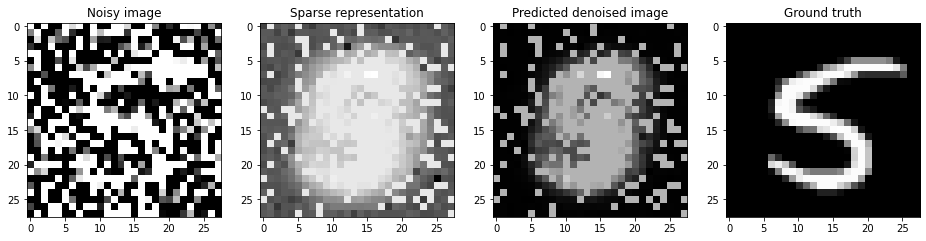

In [45]:
(noisy, normal), labels = next(iter(loader))
noisy = torch.flatten(noisy, 1)
normal = torch.flatten(normal, 1)

output = lista(noisy)
sparse_rep = output

output = network(output)

output = output.reshape(8, 28, 28)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(noisy.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[1].imshow(sparse_rep.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[2].imshow(output.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[3].imshow(normal.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')

ax[0].set_title('Noisy image')
ax[1].set_title('Sparse representation')
ax[2].set_title('Predicted denoised image')
ax[3].set_title('Ground truth')

plt.show()